In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import matplotlib.ticker as ticker
import pandas as pd
import helmeos

In [2]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
working_directory = '/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile'
n = 100
gconst = 6.67430e-8
clight = 2.99792458e10
solar = 1.98847e33
lencgs2code = (clight**2)/(solar*gconst)
masscgs2code = (1.0e0/solar)
rhocgs2code = (masscgs2code/lencgs2code**3)
tcgs2code = (clight**3)/(solar*gconst)
energycgs2code = (1.0E0/clight**2)
me2 = 9.1093837015e-28*masscgs2code
mb2 = 1.66053906660e-24*masscgs2code
ye = 0.5e0
h_bar = (1.054571817e-27)*(lencgs2code**2*masscgs2code/tcgs2code)
amax = (me2**4)/(2.4e1*np.pi**2*h_bar**3)
bmax = (mb2*me2**3)/(3.0e0*np.pi**2*h_bar**3*ye)

In [4]:
def xe(rho):
    return (rho/bmax)**(1.0e0/3.0e0)
def dpdx(x):
    return 8.0e0*x**4/np.sqrt(x**2 + 1.0e0)
def cs(rho):
    return np.sqrt(amax*dpdx(xe(rho))/3.0e0/(rho**2*bmax)**(1.0e0/3.0e0))

In [5]:
def easy_animation(xxf,yyf,data_list, name, ani_name):
    data_list_arr = np.array(data_list)
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    vmin = np.min(data_list_arr)
    vmax = np.max(data_list_arr)
    print(vmin)
    print(vmax)
    for i in range(len(data_list)):
        prim = data_list[i]
        quan = prim
        plt.pcolormesh(xxf,yyf,quan,vmin=vmin,vmax=vmax)
        ax.text(0.3, 1.01, str(name)+ ' at time step ' +str(i), transform=ax.transAxes)
        camera.snap()
    plt.colorbar(format=ticker.FuncFormatter(fmt))
    plt.annotate('max = '+np.format_float_scientific(vmax, precision=3, exp_digits=1), xy=(0.05, 0.95), xycoords='axes fraction', color = 'red')
    plt.annotate('min = '+np.format_float_scientific(vmin, precision=3, exp_digits=1), xy=(0.05, 0.9), xycoords='axes fraction', color = 'red')
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()
def easy_animation_levelset(xx,yy,xxf,yyf,data_list, levelset, name, ani_name):
    data_list_arr = np.array(data_list)
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    vmin = np.min(data_list_arr)
    vmax = np.max(data_list_arr)
    print(vmin)
    print(vmax)
    for i in range(len(data_list)):
        prim = data_list[i]
        quan = prim
        plt.contour(xx,yy,levelset[i],levels=[0],colors=['red'])
        plt.pcolormesh(xxf,yyf,quan,vmin=vmin,vmax=vmax,cmap='inferno')
        ax.text(0.3, 1.01, str(name)+ ' at time step ' +str(i), transform=ax.transAxes)
        camera.snap()
    plt.colorbar(format=ticker.FuncFormatter(fmt))
    plt.annotate('max = '+np.format_float_scientific(vmax, precision=3, exp_digits=1), xy=(0.05, 0.95), xycoords='axes fraction', color = 'red')
    plt.annotate('min = '+np.format_float_scientific(vmin, precision=3, exp_digits=1), xy=(0.05, 0.9), xycoords='axes fraction', color = 'red')
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()
def easy_animation_bfield(x1c,x3c,xxf,yyf,data_list, bfield, name, ani_name):
    data_list_arr = np.array(data_list)
    bfield_arr = np.array(bfield)
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    vmin = np.min(data_list_arr)
    vmax = np.max(data_list_arr)
    bmin = np.min(bfield_arr)
    bmax = np.max(bfield_arr)
    print(vmin)
    print(vmax)
    for i in range(len(data_list)):
        prim = data_list[i]
        quan = prim
        plt.pcolormesh(xxf,yyf,quan,vmin=vmin,vmax=vmax,cmap='binary')
        plt.streamplot(x1c,x3c,bfield[i][0,:,:].T,bfield[0][2,:,:].T, density = 1.5, color=np.log(mag_list[i][0,:,:].T**2+mag_list[0][2,:,:].T**2), cmap='inferno')
        ax.text(0.3, 1.01, str(name)+ ' at time step ' +str(i), transform=ax.transAxes)
        camera.snap()
    plt.colorbar(format=ticker.FuncFormatter(fmt))
    plt.annotate('max = '+np.format_float_scientific(bmin, precision=3, exp_digits=1), xy=(0.05, 0.95), xycoords='axes fraction', color = 'red')
    plt.annotate('min = '+np.format_float_scientific(bmax, precision=3, exp_digits=1), xy=(0.05, 0.9), xycoords='axes fraction', color = 'red')
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()

def animation_1D(x1c,data_list, log_flag, name, ani_name):
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    j = 0
    for i in data_list:
        j+= 1
        m = int(i.shape[1]/2)
        if log_flag == 1:
            plt.plot(x1c,np.log(i[:,m]), c = 'black')
        else:
            plt.plot(x1c,i[:,m],c='black')
        ax.text(0.25, 1.01, str(name)+ ' at time step ' +str(j), transform=ax.transAxes)
        camera.snap()
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()

In [6]:
def helmeos_e(dens, temp, abar, zbar):
    out = helmeos.eos_DT(dens, temp, abar, zbar)
    return out['etot']/energycgs2code
def helmeos_p(dens, temp, abar, zbar):
    out = helmeos.eos_DT(dens, temp, abar, zbar)
    return out['ptot']/(masscgs2code*energycgs2code/lencgs2code**3)
def helmeos_cs(dens, temp, abar, zbar):
    out = helmeos.eos_DT(dens, temp, abar, zbar)
    return out['cs']/clight

In [7]:
# Face value
x1f = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_x1_fgrid.dat').T
x3f = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_x3_fgrid.dat').T
# Center value
x1f = x1f [3:-3]*lencgs2code # Remove BC
x1c = (x1f[1:]+x1f[:-1])/2 #mid pt
x3f = x3f[3:-3]*lencgs2code # Remove BC
x3c = (x3f[1:]+x3f[:-1])/2 #mid pt

xx,yy= np.meshgrid(x1c,x3c,indexing='ij')

xxf, yyf = np.meshgrid(x1f,x3f,indexing='ij')

In [8]:
# Initial Values
irho = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_rho.dat').T*rhocgs2code
ieps = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_eps.dat').T*energycgs2code
ivz = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_vphi.dat').T
iHe4 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xhe4.dat').T
iC12 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xc12.dat').T
iO16 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xo16.dat').T
iNe20 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xne20.dat').T
iMg24 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xmg24.dat').T
iSi28 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xsi28.dat').T
iNi56 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xni56.dat').T

In [9]:
# Free fall time compared to simulation time (cgs)
ff_time = np.sqrt((3*np.pi)/(32*gconst*np.average(irho/rhocgs2code)))
print(ff_time)

0.5313102157129986


In [10]:
filename = working_directory+"/rkiter-0-nm.hdf5"
f = h5py.File(filename, "r")
f.keys()

<KeysViewHDF5 ['abar', 'bfield', 'coordinate', 'cs', 'dimension', 'epsilon', 'flame_state', 'phi', 'primitive', 'temp', 'time', 'x-interface', 'y-interface', 'z-interface', 'zbar']>

In [11]:
prim_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    primitive = f['primitive'][:]
    primitive = primitive.T
    prim_list.append(primitive)
    f.close()

epsilon_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    epsilon = f['epsilon'][:]
    epsilon = epsilon.T
    epsilon_list.append(epsilon)
    f.close()

temp_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    temp = f['temp'][:]
    temp = temp.T
    temp_list.append(temp)
    f.close()

mag_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    mag = f['bfield'][2:-1,1,2:-1,:]
    mag = mag.T
    mag_list.append(mag)
    f.close()
abar_list = []
zbar_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    abar = f['abar'][:]
    abar = abar.T
    abar_list.append(abar)
    f.close()
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    zbar = f['zbar'][:]
    zbar = zbar.T
    zbar_list.append(zbar)
    f.close()

In [12]:
dx2 = np.diff(xxf[:,0]**2)
dy = np.diff(yyf[0,:])
dxx2,dyy = np.meshgrid(dx2,dy)
vol = dxx2*dyy*np.pi
mass_list = []
turbq_list = []
for prim in prim_list:
    mass = np.sum(prim[0,1:-1,1,1:-1].T*vol)
    mass_list.append(mass)
    mass = np.sum(prim[0,1:-1,1,1:-1].T*vol)
    mass_list.append(mass)
mass_arr = np.array(mass_list)
energy_list = []
for eps in epsilon_list:
    energy = np.sum(eps[1:-1,1,1:-1].T*vol)
    energy_list.append(energy)
energy_arr = np.array(energy_list)

toten_list = []
for i in range(len(prim_list)):
    inten = np.sum(epsilon_list[i][1:-1,1,1:-1].T*vol)
    v2 = prim_list[i][1,1:-1,1,1:-1]**2+xx**2*prim_list[i][2,1:-1,1,1:-1]**2+prim_list[i][3,1:-1,1,1:-1]**2
    ke = np.sum(prim_list[i][0,1:-1,1,1:-1].T*v2.T*vol)/2
    mag = np.sum((mag_list[i][:,:,0]**2+mag_list[i][:,:,1]**2+mag_list[i][:,:,2]**2).T)/2
    toten_list.append(inten+ke+mag)

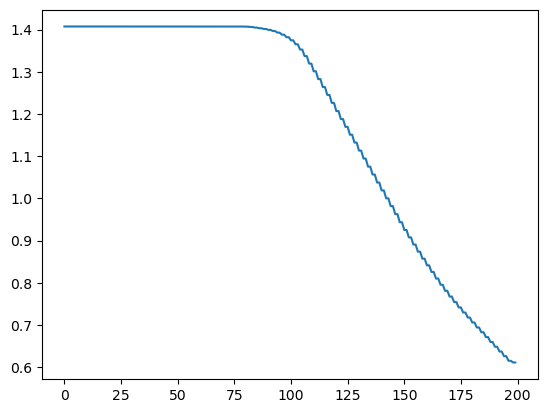

In [13]:
plt.plot(mass_list)

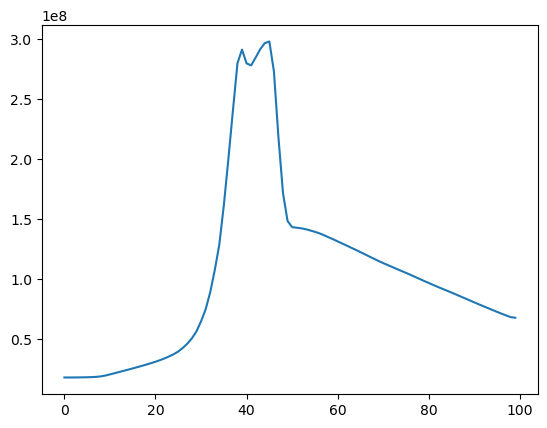

In [14]:
plt.plot(toten_list)

In [15]:
C_list = []
for i in range(len(prim_list)):
    C_list.append(prim_list[i][7,1:-1,1,1:-1])
animation_1D(x1c,C_list, 1, 'C', 'eq_logC')

/tmp/ipykernel_34475/2346747047.py:79: RuntimeWarning: divide by zero encountered in log
  plt.plot(x1c,np.log(i[:,m]), c = 'black')


In [16]:
scaG1_list = []
for i in range(len(prim_list)):
    scaG1_list.append(prim_list[i][14,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.log(np.array(scaG1_list)),'log_scaG1', 'log_scaG1')
animation_1D(x1c,scaG1_list, 0, 'scaG1', 'eq_scaG1')

/tmp/ipykernel_34475/4047440339.py:4: RuntimeWarning: invalid value encountered in log
  easy_animation(xxf,yyf,np.log(np.array(scaG1_list)),'log_scaG1', 'log_scaG1')


nan
nan


In [17]:
scaG2_list = []
for i in range(len(prim_list)):
    scaG2_list.append(prim_list[i][15,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.log(np.array(scaG2_list)),'log_scaG2', 'log_scaG2')
animation_1D(x1c,scaG2_list, 0, 'scaG2', 'eq_scaG2')

/tmp/ipykernel_34475/866915953.py:4: RuntimeWarning: divide by zero encountered in log
  easy_animation(xxf,yyf,np.log(np.array(scaG2_list)),'log_scaG2', 'log_scaG2')
/tmp/ipykernel_34475/866915953.py:4: RuntimeWarning: invalid value encountered in log
  easy_animation(xxf,yyf,np.log(np.array(scaG2_list)),'log_scaG2', 'log_scaG2')


nan
nan


In [18]:
dens_list = []
for i in range(len(prim_list)):
    dens_list.append(prim_list[i][0,1:-1,1,1:-1])
easy_animation_levelset(xx,yy,xxf,yyf,np.array(np.log(dens_list)),scaG1_list,'log_rho', 'log_rho')

-34.05817060795703
-18.05184586375479


In [19]:
animation_1D(x1c,dens_list, 1, 'Log equatorial density', 'eq_dens')

In [20]:
temp_anilist = []
for i in range(len(temp_list)):
    temp_anilist.append(temp_list[i][1:-1,1, 1:-1])
easy_animation_levelset(xx,yy,xxf,yyf,np.log(np.array(temp_anilist)),scaG1_list,'log_temp', 'log_temp')

-9.210340371976182
2.420781363181032


In [21]:
animation_1D(x1c,temp_anilist, 1, 'equatorial temp', 'eq_temp')

In [22]:
eps_anilist = []
for i in range(len(epsilon_list)):
    eps_anilist.append(epsilon_list[i][1:-1,1, 1:-1])
# easy_animation(xxf,yyf,np.log(np.array(eps_anilist)),'log_eps', 'log_eps')
easy_animation_levelset(xx,yy,xxf,yyf,np.log(np.array(eps_anilist)), scaG1_list,'log_eps', 'log_eps')

-12.818987656506247
-5.357094358864415


In [23]:
animation_1D(x1c,eps_anilist, 1, 'log equatorial eps', 'eq_eps')

In [24]:
abar_anilist = []
for i in range(len(abar_list)):
    abar_anilist.append(abar_list[i][1:-1,1, 1:-1])
animation_1D(x1c,abar_anilist, 0, 'equatorial abar', 'eq_abar')
easy_animation_levelset(xx,yy,xxf,yyf,abar_anilist,scaG1_list, 'abar', 'abar')
zbar_anilist = []
for i in range(len(zbar_list)):
    zbar_anilist.append(zbar_list[i][1:-1,1, 1:-1])
animation_1D(x1c,zbar_anilist, 0, 'equatorial zbar', 'eq_zbar')
easy_animation_levelset(xx,yy,xxf,yyf,zbar_anilist,scaG1_list, 'zbar', 'zbar')

4.0
56.0
2.0
28.0


In [25]:
tau_list = []
for i in range(len(prim_list)):
    tau_list.append(prim_list[i][4,1:-1,1,1:-1])
easy_animation_levelset(xx,yy,xxf,yyf,np.array(tau_list), scaG1_list,'tau', 'tau')

8.129635729173634e-21
1.8735810088843194e-11


In [26]:
vz_list = []
for i in range(len(prim_list)):
    vz_list.append(prim_list[i][3,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(vz_list), 'vz', 'vz')

-0.09603254732844381
0.11018413596827635


In [27]:
vx_list = []
for i in range(len(prim_list)):
    vx_list.append(prim_list[i][1,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(vx_list), 'vx', 'vx')

-0.03895664816935982
0.10789190576899153


In [28]:
easy_animation_bfield(x1c,x3c,xxf,yyf,np.log(dens_list), mag_list, 'poloidal_field', 'poloidal_field')

-34.05817060795703
-18.05184586375479
